In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel

import cv2

In [2]:
ipath = os.path.join('assets', '1.png')
os.path.exists(ipath)

True

In [3]:
img = plt.imread(ipath)[:, :, :3]
gimg = rgb2gray(img)
img.shape, gimg.shape

((901, 771, 3), (901, 771))

In [4]:
fsize = (7,7)

def show_image(image, figsize=fsize):
    gray_image = len(image.shape) == 2
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image, cmap="gray" if gray_image else None)
    plt.show()

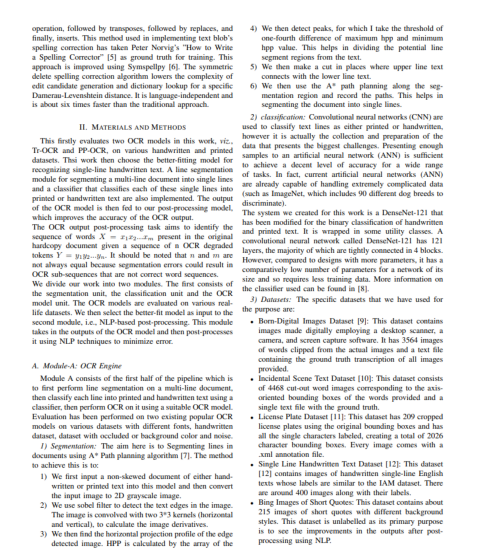

In [5]:
show_image(img)

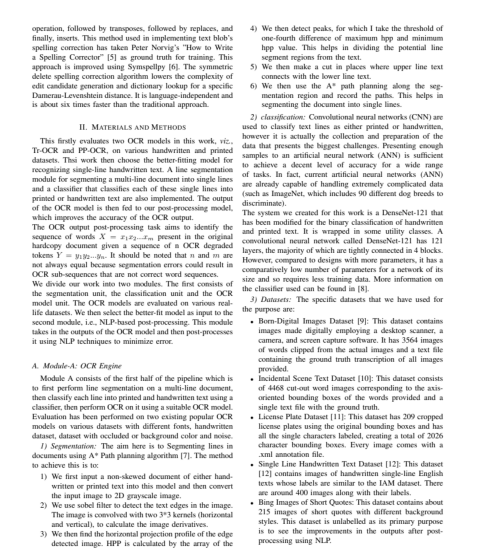

In [6]:
show_image(gimg)

In [7]:
from skimage.filters import threshold_otsu

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(image):
    threshold = threshold_otsu(image)
    return image < threshold

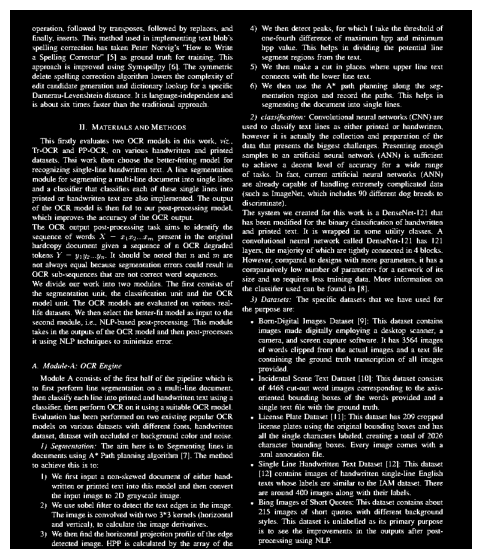

In [8]:
bin_img = binarize_image(gimg)
show_image(bin_img)

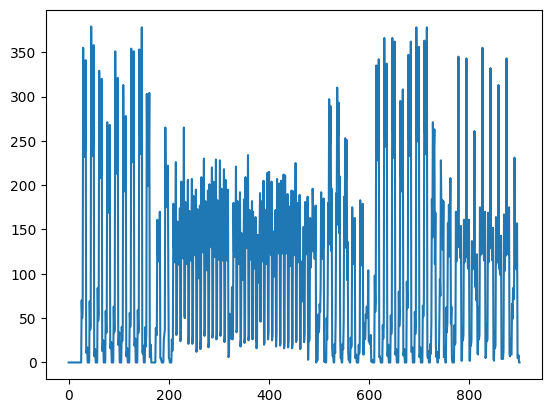

In [9]:
hpp = horizontal_projections(bin_img)
plt.plot(hpp);

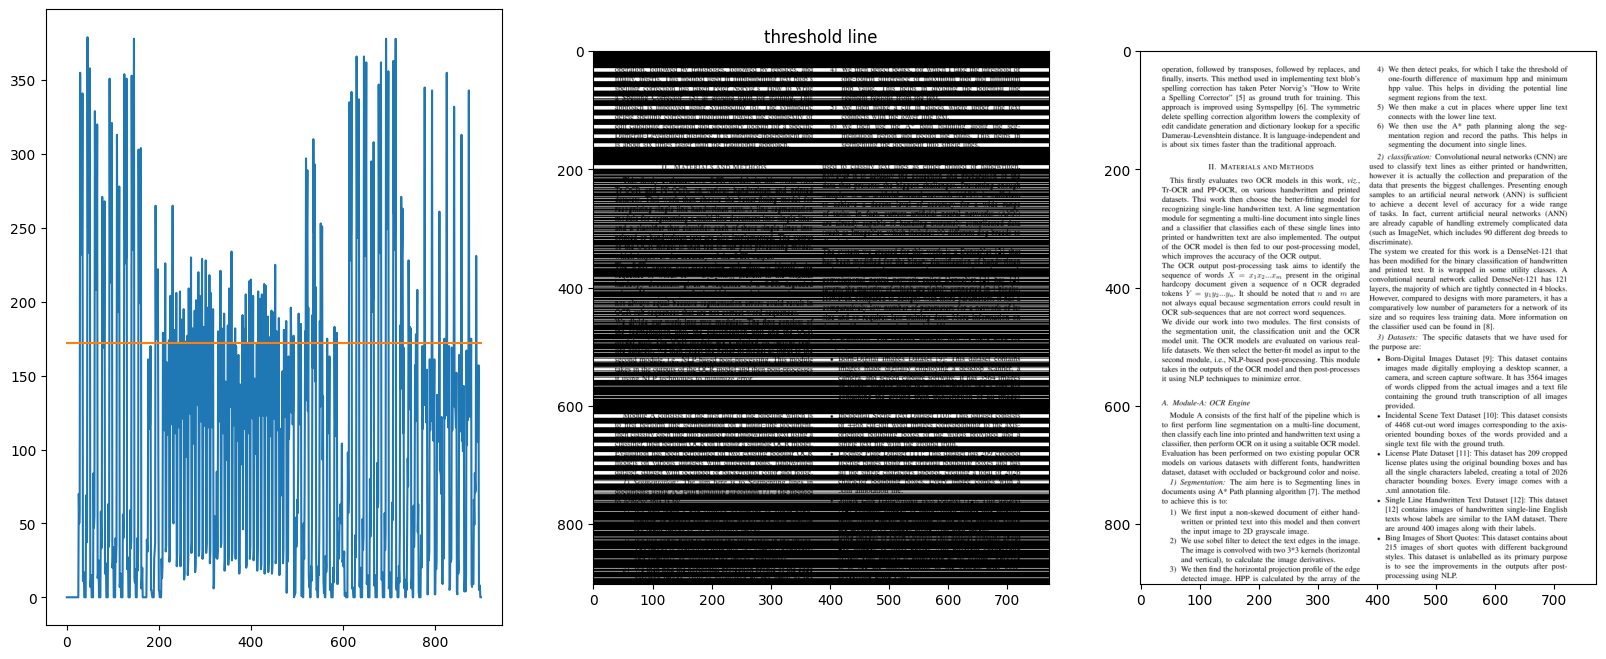

In [10]:
def find_peak_regions(hpp, threshold):
    
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

threshold = (np.max(hpp)-np.min(hpp))/2.2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(gimg)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
ax3.imshow(gimg, cmap="gray")
plt.show()

In [11]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 13


In [12]:
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

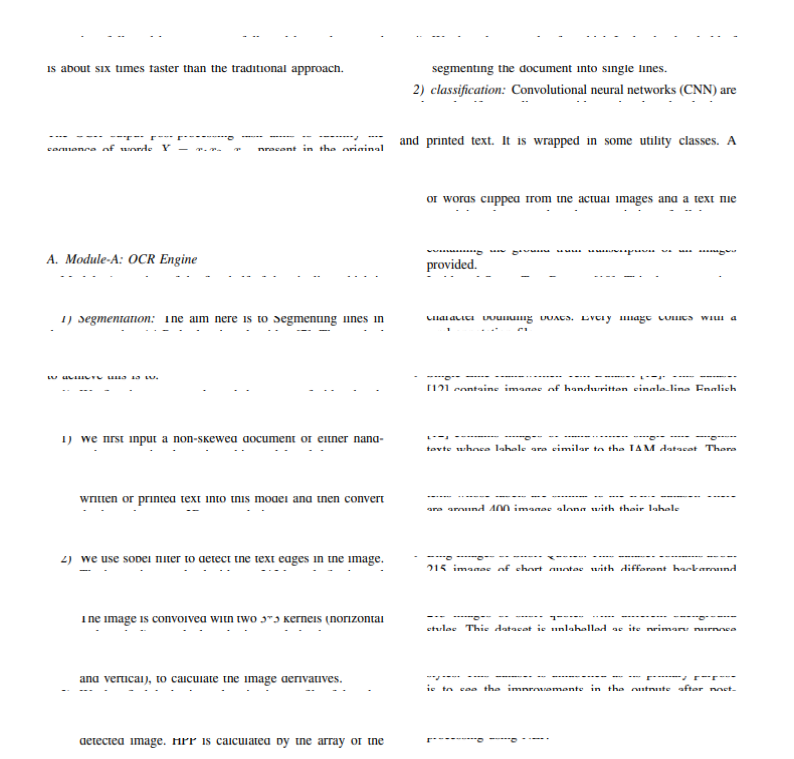

In [13]:
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(10,10))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [14]:
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(gimg)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = sub_image_index[0]
    path[:,0] += offset_from_top
    segment_separating_lines.append(path)

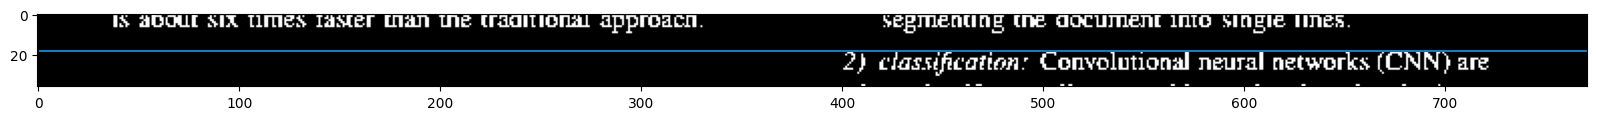

In [15]:
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

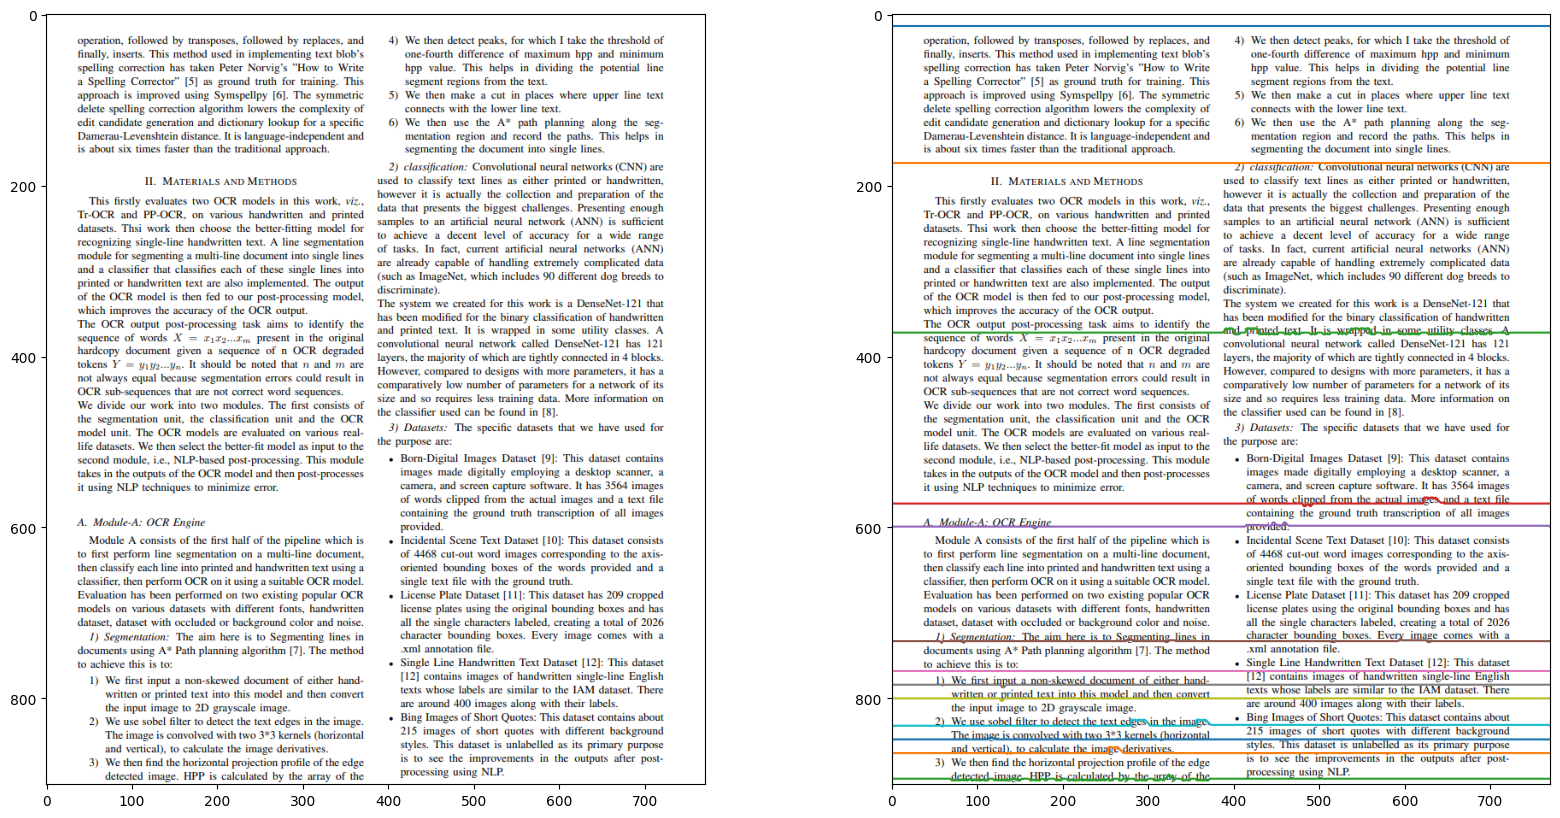

In [16]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

In [17]:
def segment_text_lines(image_path, output_prefix=None, min_line_height=15):
    """
    Segments text lines (horizontal or slightly skewed) from a document image.

    Args:
        image_path (str): Path to the input document image.
        output_prefix (str): Prefix for saving extracted lines.
        min_line_height (int): Minimum pixel height for a valid text line.

    Returns:
        list of (line_image, (x, y, w, h)): Extracted line images and their bounding boxes.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Cannot load image from {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Binarize: assume dark text on light background
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Use dilation to connect text horizontally into lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 5))
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # Extract contours corresponding to text lines
    cnts, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    lines = []
    for idx, contour in enumerate(cnts):
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small artifacts
        if h < min_line_height or w < 50:
            continue

        # Extract and save each line
        line_img = img[y:y+h, x:x+w]
        if output_prefix:
            filename = f"{output_prefix}_{idx:03d}.png"
            cv2.imwrite(filename, line_img)
        lines.append((line_img, (x, y, w, h)))

    # Sort by top-to-bottom (y-coordinate)
    lines = sorted(lines, key=lambda item: item[1][1])

    return lines

In [18]:
def show_segmented_lines_from_array(image, boxes):
    """
    Display an image with bounding boxes drawn around text lines.

    Args:
        image (numpy.ndarray): Original image array (BGR format from OpenCV).
        boxes (list): List of (x, y, w, h) tuples for each line.
    """
    img_display = image.copy()

    for (x, y, w, h) in boxes:
        print((x, y, w, h))
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert to RGB for matplotlib
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(img_display)
    plt.axis("off")
    plt.title("Detected Text Lines")
    plt.show()

In [19]:
lines = segment_text_lines(ipath)
len(lines)

4

(0, 24, 771, 143)
(0, 172, 771, 595)
(0, 588, 236, 16)
(2, 752, 769, 149)


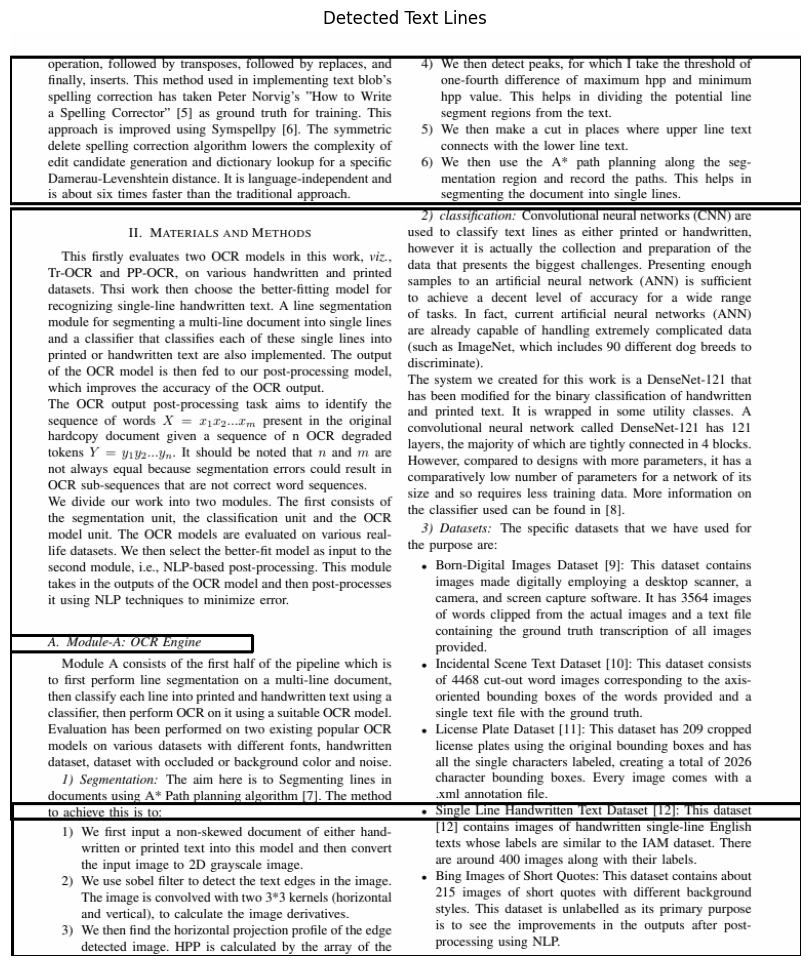

In [20]:
show_segmented_lines_from_array(gimg, list(zip(*lines))[1])

In [21]:
import layoutparser as lp
import cv2

# Load a pre-trained PubLayNet model
model = lp.models.Detectron2LayoutModel(
    config_path="lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config",
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5]
)

# Detect layout
layout = model.detect(img)

# Filter for only text regions
text_blocks = lp.Layout([b for b in layout if b.type == "Text"])

# Draw results
viz = lp.draw_box(img, text_blocks, box_width=3, color_map={"Text": (0, 255, 0)})
cv2.imshow("Segmented Lines", viz)
cv2.waitKey(0)


ImportError: 
Detectron2LayoutModel requires the detectron2 library but it was not found in your environment. Checkout the instructions on the
installation page: https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md and follow the ones
that match your environment. Typically the following would work for MacOS or Linux CPU machines:
    pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 


In [90]:
dir(lp.Layout)

['__abstractmethods__',
 '__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'append',
 'clear',
 'condition_on',
 'copy',
 'count',
 'crop_image',
 'extend',
 'filter_by',
 'get_homogeneous_blocks',
 'get_info',
 'get_texts',
 'index',
 'insert',
 'is_in',
 'pad',
 'pop',
 'relative_to',
 'remove',
 'reverse',
 'scale',
 'shift',
 'sort',
 'to_dataframe',
 'to_dict']